In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_rec_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_rec_date = dt.datetime.strptime(most_rec_date[0], '%Y-%m-%d').date()
most_rec_date

datetime.date(2017, 8, 23)

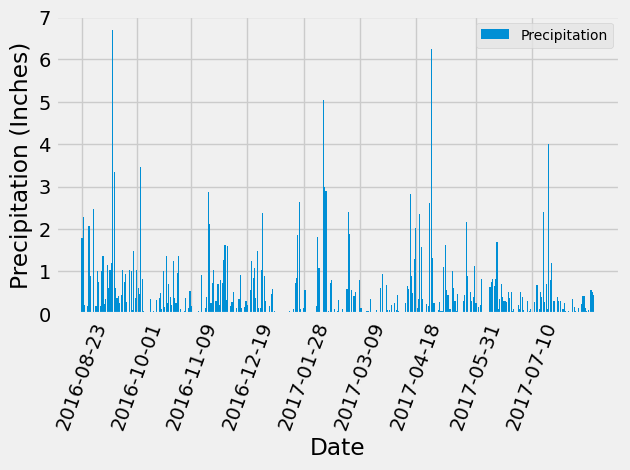

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = most_rec_date - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
recent_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= query_date)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_data = pd.DataFrame(recent_data)
prcp_data = prcp_data.rename(columns={
    'date': 'Date',
    'prcp': 'Precipitation'
})
prcp_data = prcp_data.dropna()
# Sort the dataframe by date
prcp_data = prcp_data.sort_values('Date')
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
x = prcp_data.Date
y = prcp_data.Precipitation
labels = ['2016-08-23','2016-10-01','2016-11-09','2016-12-19','2017-01-28','2017-03-09','2017-04-18','2017-05-31','2017-07-10']
ax.bar(x, y, label='Precipitation')
ax.set_ylabel('Precipitation (Inches)')
ax.set_xlabel('Date')
ax.set_xticks(labels)
plt.xticks(rotation=70)
plt.style.use('ggplot')
plt.legend()
fig.tight_layout()
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
y.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
sta_total = session.query(station.station).count()
sta_total

9

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
act_sta = session.query(measurement.station, func.count(measurement.station)).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).all()

act_sta

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_act_data = session.query(func.min(measurement.tobs),
    func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
most_act_data

[(54.0, 85.0, 71.66378066378067)]

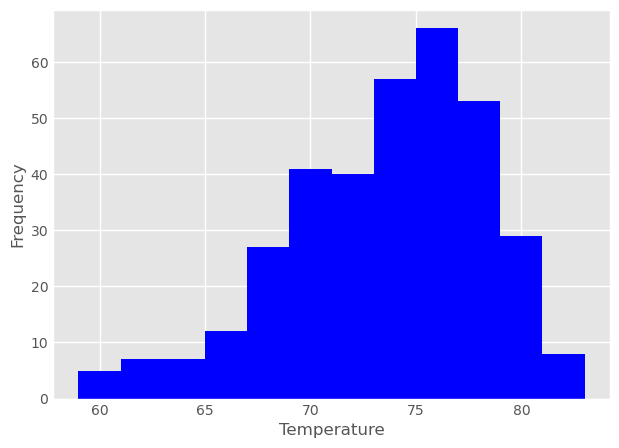

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_act_data = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= query_date).all()
most_act_data = pd.DataFrame(most_act_data)

fig, ax = plt.subplots()
x = most_act_data
ax.hist(x, bins=12, color='blue')
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
plt.show()

# Close Session

In [19]:
# Close Session
session.close()